# **Part A**

## **Context**

Company X owns a movie application and repository that caters to movie streaming to millions of users on a subscription basis. The company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on the cast information button, the app will show details of the actor in the scene. The company has in-house computer vision and multimedia experts who need to detect faces from screenshots of the movie scene.

**Objective**

To build a face detection system



**Data Dictionary**

**label:** Identifies the object in the image

**notes:** Additional comments (currently empty)

**points:** Co-ordinates of the mask (top-left and bottom-right)

**imageWidth:** Width of the image in pixels

**imageHeight:** Height of the image in pixels


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import numpy as np
data = np.load('/content/drive/MyDrive/Images.npy', allow_pickle=True)
print(f"Number of image-mask pairs: {len(data)}")


Number of image-mask pairs: 393


In [4]:
images = [item[0] for item in data]  # image is at index 0
masks = [item[1] for item in data]  # mask is at index 1


#printing the count of images and maskes
print(f"Number of img entries : {len(images)}")
print(f"Number of mask entries: {len(masks)}")


Number of img entries : 393
Number of mask entries: 393


In [5]:
print("Type:", type(masks))
print("Dtype:", getattr(masks, 'dtype', 'No dtype'))
print("Shape:", getattr(masks, 'shape', 'No shape'))

print("First few entries:", masks[:5] if isinstance(masks, (list, np.ndarray)) else masks)


Type: <class 'list'>
Dtype: No dtype
Shape: No shape
First few entries: [[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}], [{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}], [{'label': ['Face'], 'notes': '', 'points': [{'x': 0.495, 'y': 0.27147766323024053}, {'x': 0.595, 'y': 0.46048109965635736}], 'imageWidth': 600, 'imageHeight': 291}], [{'label': ['Face'], 'notes': '', 'points': [{'x': 0.5586206896551724, 'y': 0.19938650306748465}, {'x': 0.6603448275862069, 'y': 0.3773006134969325}], 'imageWidth': 580, 'imageHeight':

In [6]:
print("Type of images:", type(images))
print("Type of images[0]:", type(images[0]))
print("Sample image entry:", images[0])


Type of images: <class 'list'>
Type of images[0]: <class 'numpy.ndarray'>
Sample image entry: [[[42 37 34]
  [56 51 48]
  [71 66 63]
  ...
  [23 33 34]
  [26 36 37]
  [28 38 39]]

 [[40 35 32]
  [51 46 43]
  [64 59 56]
  ...
  [27 36 35]
  [24 33 32]
  [26 35 34]]

 [[43 38 35]
  [51 46 43]
  [61 56 53]
  ...
  [28 30 27]
  [33 35 32]
  [35 37 34]]

 ...

 [[56 47 40]
  [57 48 41]
  [61 52 45]
  ...
  [67 48 42]
  [55 35 28]
  [60 40 33]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [60 40 33]
  [54 34 27]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [70 50 43]
  [64 44 37]]]


In [7]:
import numpy as np
import cv2

# Resize target shape
target_size = (128, 128)

def create_mask_from_annotations(annotations, image_shape):
    height, width = image_shape
    mask = np.zeros((height, width), dtype=np.uint8)

    for obj in annotations:
        points = obj['points']
        x1 = int(points[0]['x'] * width)
        y1 = int(points[0]['y'] * height)
        x2 = int(points[1]['x'] * width)
        y2 = int(points[1]['y'] * height)
        cv2.rectangle(mask, (x1, y1), (x2, y2), color=255, thickness=-1)

    return mask


In [8]:
generated_masks = []

for i in range(len(images)):
    img = images[i]
    annot = masks[i]
    h, w = img.shape[:2]

    # Create mask from annotations
    mask = create_mask_from_annotations(annot, (h, w))

    # Resize image and mask
    resized_img = cv2.resize(img, target_size)
    resized_mask = cv2.resize(mask, target_size)

    # Store them
    images[i] = resized_img
    generated_masks.append(resized_mask)


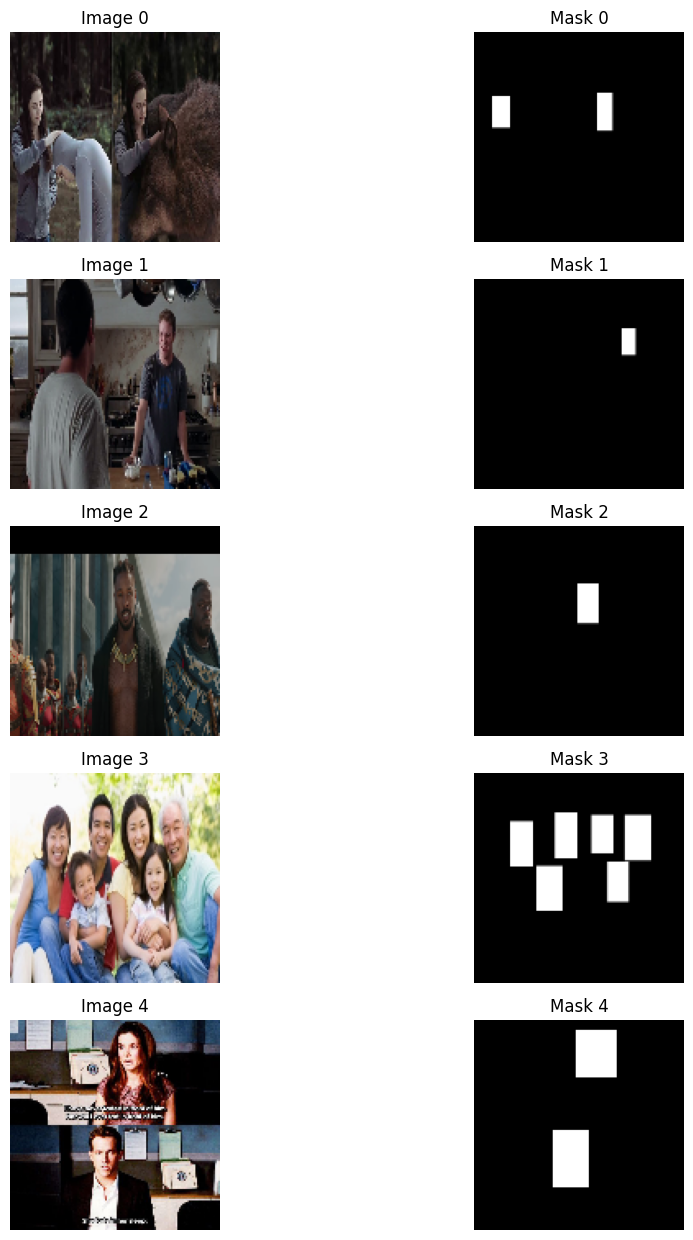

In [9]:
import matplotlib.pyplot as plt

def visualize_images_with_masks(images, masks, count=5):
    plt.figure(figsize=(12, count * 2.5))

    for i in range(count):
        # Show image
        plt.subplot(count, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i}')
        plt.axis('off')

        # Show corresponding mask
        plt.subplot(count, 2, 2*i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Using resized arrays
visualize_images_with_masks(images, generated_masks, count=5)


In [10]:
from sklearn.model_selection import train_test_split
clean_images = []
clean_masks = []

for img, mask in zip(images, generated_masks):
    if isinstance(img, np.ndarray) and img.shape == (128, 128, 3) and \
       isinstance(mask, np.ndarray) and mask.shape == (128, 128):
        clean_images.append(img.astype(np.float32) / 255.0)
        clean_masks.append(mask.astype(np.float32) / 255.0)

# Convert to arrays
images_array = np.array(clean_images)
masks_array = np.expand_dims(np.array(clean_masks), axis=-1)

# Check final matching sizes
print("Final image count:", images_array.shape[0])
print("Final mask count:", masks_array.shape[0])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    images_array, masks_array, test_size=0.2, random_state=42
)

print("Train image shape:", X_train.shape)
print("Train mask shape:", y_train.shape)



Final image count: 381
Final mask count: 381
Train image shape: (304, 128, 128, 3)
Train mask shape: (304, 128, 128, 1)


#### **Model Building and Evaluation**

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Combined BCE + Dice Loss
def combined_bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

# U-Net Model
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(shape=input_size, name="input_layer")

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    return models.Model(inputs=inputs, outputs=outputs)

# Build and compile the model
model = unet_model()
model.compile(optimizer='adam', loss=combined_bce_dice_loss, metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)



Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7243 - loss: 1.4415 - val_accuracy: 0.8738 - val_loss: 1.3003
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8717 - loss: 1.3176 - val_accuracy: 0.8738 - val_loss: 1.2392
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8729 - loss: 1.2164 - val_accuracy: 0.8738 - val_loss: 1.1454
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8669 - loss: 1.1104 - val_accuracy: 0.8738 - val_loss: 1.0892
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8716 - loss: 1.0968 - val_accuracy: 0.8738 - val_loss: 1.0638
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8693 - loss: 1.0469 - val_accuracy: 0.8738 - val_loss: 1.0389
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8672 - loss: 1.0300 - val_accuracy: 0.8738 - val_loss: 1.0442
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8743 - loss: 1.0065 - val_accuracy: 0.8739 - va

In [12]:
#evaluation on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.9247 - loss: 0.4886
Train Loss: 0.4971
Train Accuracy: 0.9252


In [13]:
#defining dice coefficient and Iou score
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [14]:
# Predict on the training set
y_pred_train = model.predict(X_train)
# Apply a threshold (e.g., 0.5) to get binary masks
y_pred_train_thresh = (y_pred_train > 0.5).astype(np.uint8)

#calculating the dice score and iou score
dice_scores_train = []
iou_scores_train = []

for true, pred in zip(y_train, y_pred_train_thresh):
    dice_scores_train.append(dice_coef(true, pred))
    iou_scores_train.append(iou_score(true, pred))

print(f"Average Train Dice Coefficient: {np.mean(dice_scores_train):.4f}")
print(f"Average Train IoU Score: {np.mean(iou_scores_train):.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Average Train Dice Coefficient: 0.6703
Average Train IoU Score: 0.5293


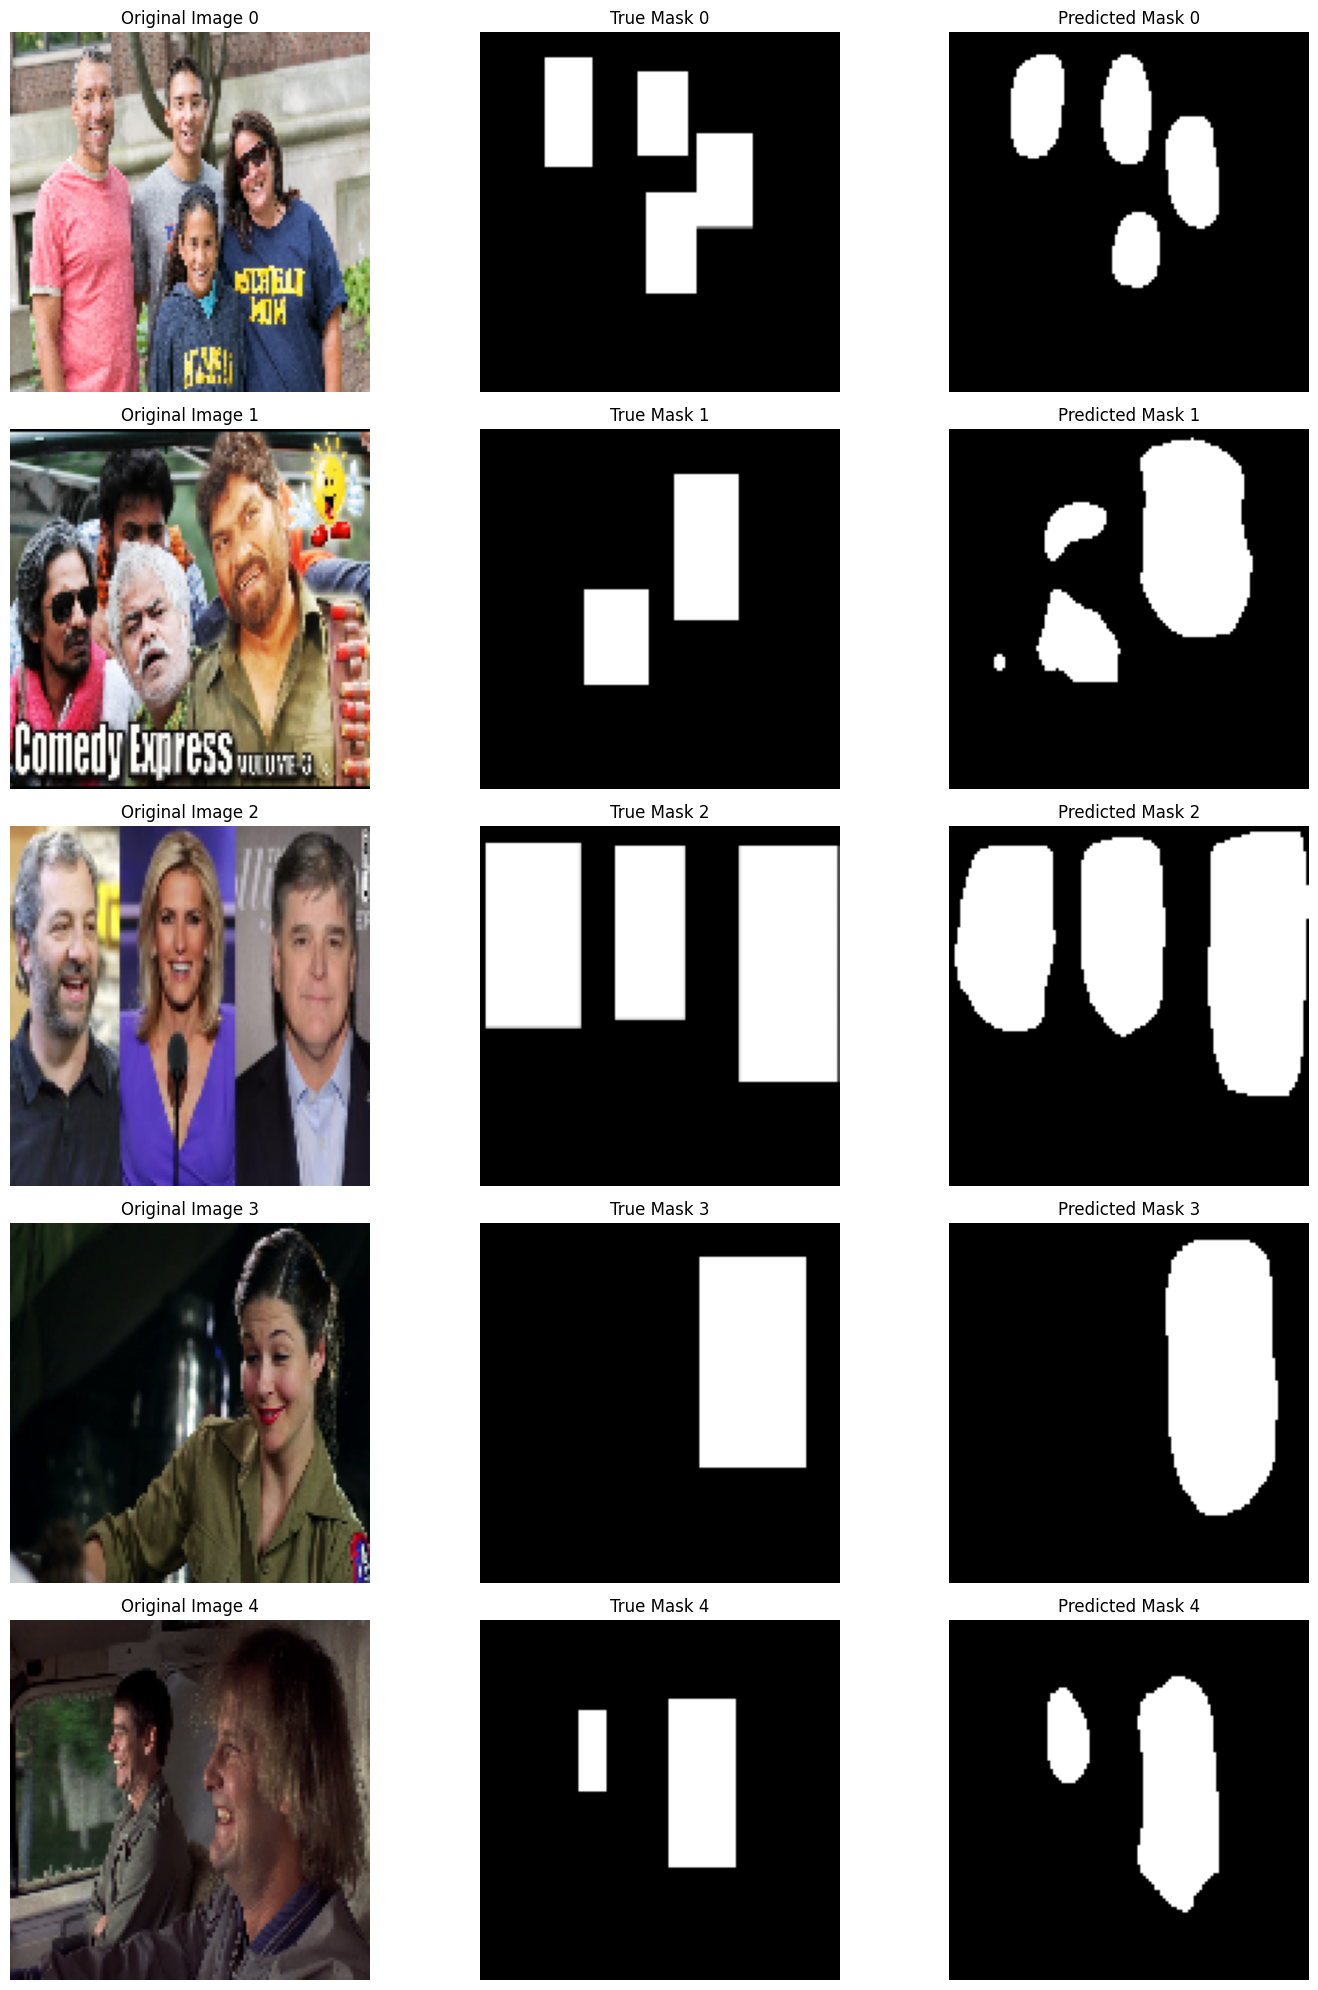

In [15]:
def visualize_predictions(images, true_masks, pred_masks, count=5):
    plt.figure(figsize=(15, count * 4))

    for i in range(count):
        # Image
        plt.subplot(count, 3, 3*i + 1)
        plt.imshow(images[i])
        plt.title(f"Original Image {i}")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(count, 3, 3*i + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title(f"True Mask {i}")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(count, 3, 3*i + 3)
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Pass X_train as the images, y_train as the true_masks, and y_pred_train_thresh as the pred_masks
visualize_predictions(X_train, y_train, y_pred_train_thresh, count=5)


In [16]:

# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8914 - loss: 0.7533
Test Loss: 0.7760
Test Accuracy: 0.8852


In [17]:
#calculating dice score and iou score on test data
dice_scores = []
iou_scores = []

# Predict on the test set
y_pred_test = model.predict(X_test)
# Apply a threshold (e.g., 0.5) to get binary masks
y_pred_test_thresh = (y_pred_test > 0.5).astype(np.uint8)


for true, pred in zip(y_test, y_pred_test_thresh):
    dice_scores.append(dice_coef(true, pred))
    iou_scores.append(iou_score(true, pred))

print(f"Average Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Average IoU Score: {np.mean(iou_scores):.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
Average Dice Coefficient: 0.5082
Average IoU Score: 0.3724


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


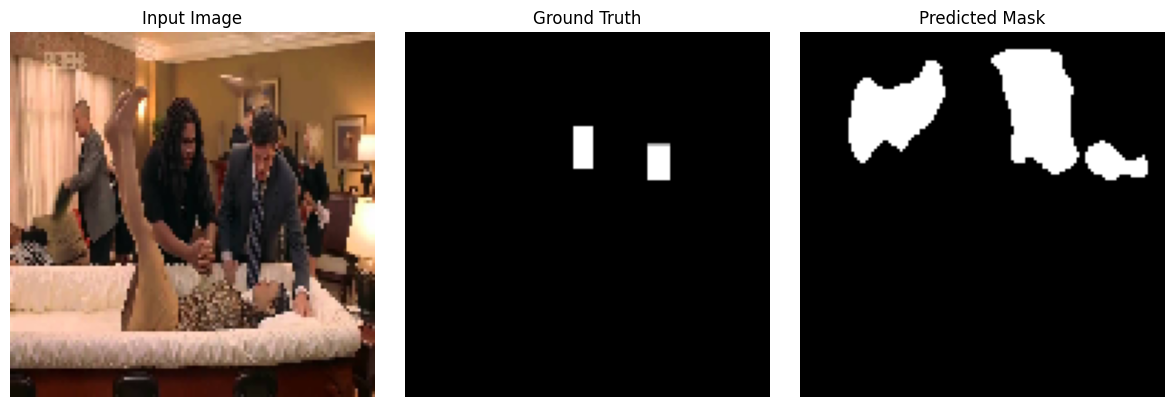

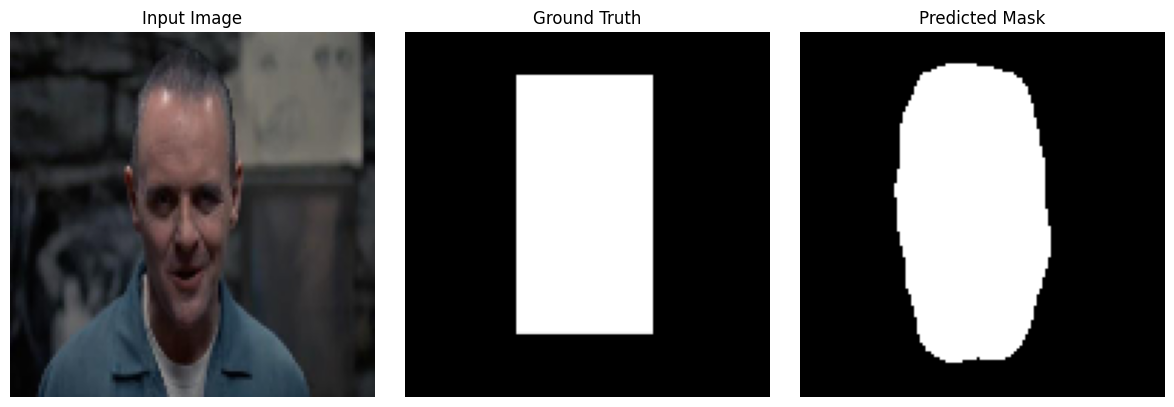

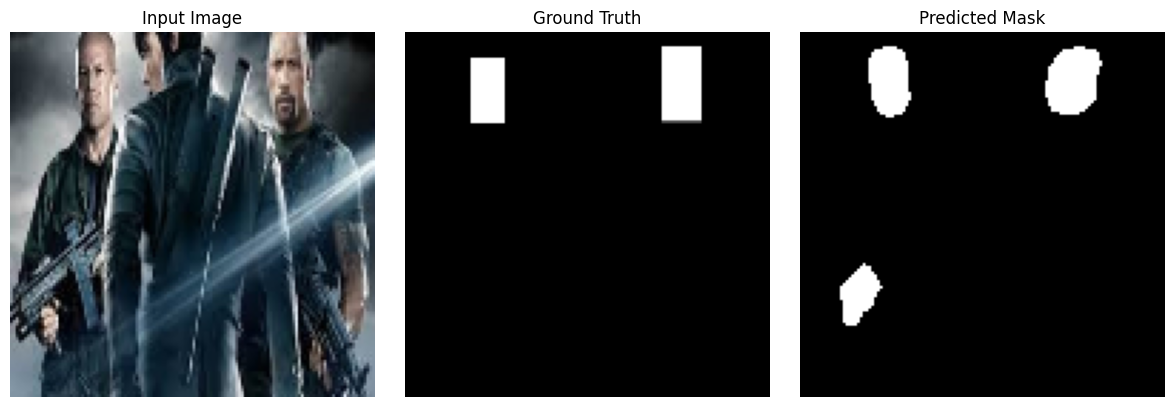

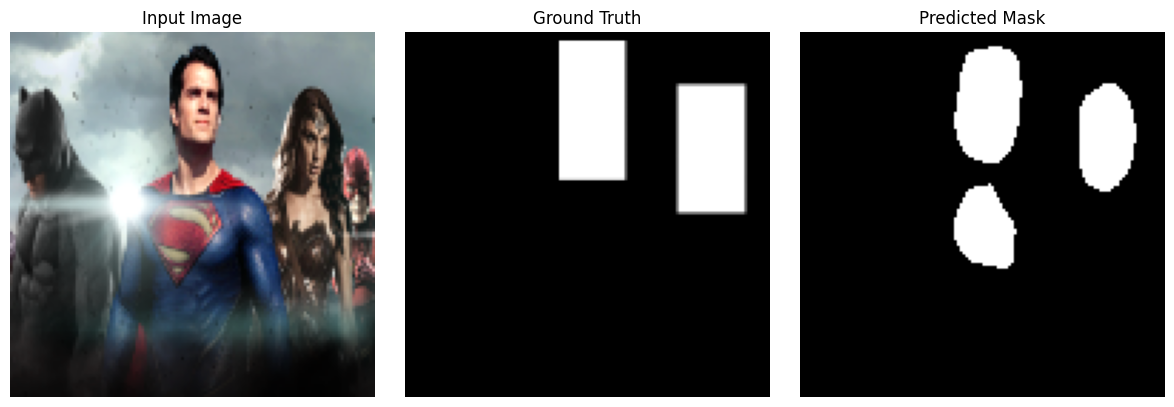

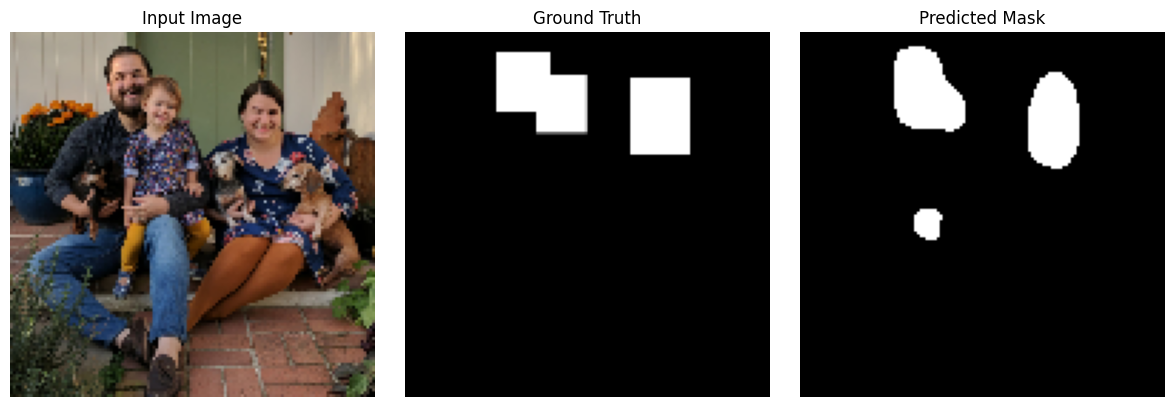

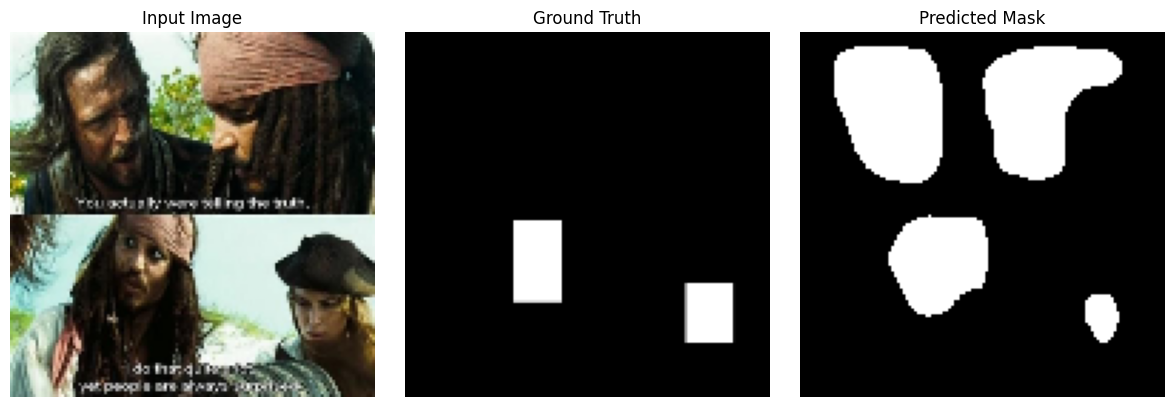

In [18]:

def visualize_predictions(model, X_test, y_test, num_samples=5):
    # Predict on test set
    preds = model.predict(X_test[:num_samples])
    preds = (preds > 0.5).astype(np.uint8)  # Binarize predictions

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth
        plt.subplot(1, 3, 2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
visualize_predictions(model, X_test, y_test, num_samples=6)







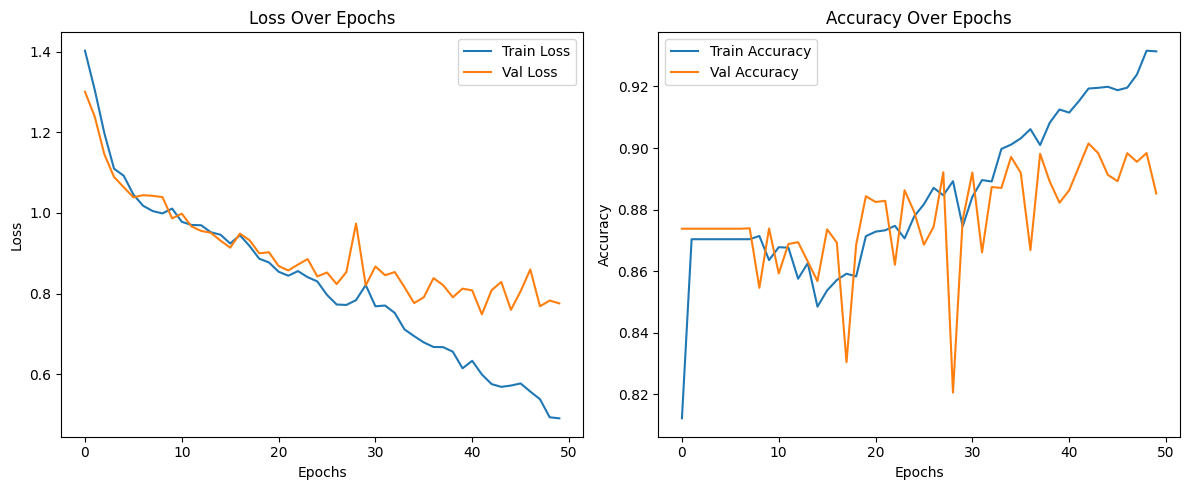

In [19]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


##**Observations :**
1. The model is predicting the mask areas quite well, but sometimes it is missing the exact edges or shape.

2. Train and test accuracy are high (more than 85%), showing the model is learning useful features and its not overfitting.

3. Dice and IoU scores are moderate, because there's still some mismatch between predicted and real masks.

4. To improve this model, we can try regulization techniquess like data augmentation, better models, or post-processing techniques.



## **Part-B**

#### **Objective**

To create an image dataset to be used by the AI team to build image classifier data

#### **Data Dictionary**

In [20]:
#importing the necessary libraries
import os
import cv2
import pandas as pd
from datetime import datetime
import zipfile

In [21]:
#Unzip the training_images from the zip file
zip_path = '/content/drive/MyDrive/training_images-20211126T092819Z-001.zip'
extract_to = '/content/training_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [22]:
# folder path where the images are stored
folder_path = '/content/training_images/training_images'


In [23]:
# Loading pretrained model Haar cascadeClassifier for face detection from cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [24]:
# getting all types of image files and their count
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f" Total images found: {len(image_files)}")



 Total images found: 1091


In [25]:
face_data = []
#Loop through each image and detect faces
for filename in image_files:
    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f" Cannot read image: {filename}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=3)

    if len(faces) == 0:
        print(f" No face detected in: {filename}")
    else:
        print(f" Detected {len(faces)} face(s) in: {filename}")

    for i, (x, y, w, h) in enumerate(faces):
        face_data.append({
            'image_name': filename,
            'face_id': i + 1,
            'x': int(x),
            'y': int(y),
            'width': int(w),
            'height': int(h),
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })



 No face detected in: real_00366.jpg
 Detected 1 face(s) in: real_00915.jpg
 Detected 1 face(s) in: real_00978.jpg
 Detected 3 face(s) in: real_00047.jpg
 Detected 1 face(s) in: real_00256.jpg
 Detected 1 face(s) in: real_00044.jpg
 Detected 1 face(s) in: real_00033.jpg
 Detected 1 face(s) in: real_00380.jpg
 Detected 1 face(s) in: real_00213.jpg
 Detected 3 face(s) in: real_00905.jpg
 Detected 1 face(s) in: real_00303.jpg
 Detected 1 face(s) in: real_00779.jpg
 Detected 1 face(s) in: real_00649.jpg
 Detected 1 face(s) in: real_00790.jpg
 Detected 2 face(s) in: real_00894.jpg
 Detected 1 face(s) in: real_00376.jpg
 No face detected in: real_00018.jpg
 No face detected in: real_00818.jpg
 Detected 2 face(s) in: real_00988.jpg
 Detected 1 face(s) in: real_00991.jpg
 Detected 1 face(s) in: real_00825.jpg
 Detected 1 face(s) in: real_00158.jpg
 Detected 1 face(s) in: real_00963.jpg
 Detected 1 face(s) in: real_00604.jpg
 Detected 1 face(s) in: real_00530.jpg
 Detected 1 face(s) in: real_00

In [26]:
# Convert to DataFrame
df_faces = pd.DataFrame(face_data)

In [27]:
# Save metadata
output_csv = '/content/face_metadata.csv'
df_faces.to_csv(output_csv, index=False)

print(f"\n Metadata saved to: {output_csv}")
print(df_faces.head())


 Metadata saved to: /content/face_metadata.csv
       image_name  face_id    x    y  width  height            timestamp
0  real_00915.jpg        1   54  165    390     390  2025-06-08 12:21:50
1  real_00978.jpg        1   50   80    465     465  2025-06-08 12:21:50
2  real_00047.jpg        1  114   92    449     449  2025-06-08 12:21:51
3  real_00047.jpg        2  159  307     89      89  2025-06-08 12:21:51
4  real_00047.jpg        3   99  477     73      73  2025-06-08 12:21:51
